In [13]:
#| label: gen-bday-rooms-fn
library(tidyverse)
exact_solution <- 1 - (prod(seq(337,366))) / (366^30)
gen_bday_room <- function(room_num=NULL) {
  num_people <- 30
  num_days <- 366
  ppl_df <- tibble(id=seq(1,num_people))
birthdays <- sample(1:num_days, num_people,replace = T)
  ppl_df['birthday'] <- birthdays
  if (!is.null(room_num)) {
    ppl_df <- ppl_df %>% mutate(room_num=room_num) %>% relocate(room_num)
  }
  return(ppl_df)
}
gen_bday_rooms <- function(num_rooms) {
  rooms_df <- tibble()
  for (r in seq(1, num_rooms)) {
      cur_room <- gen_bday_room(r)
      rooms_df <- bind_rows(rooms_df, cur_room)
  }
  return(rooms_df)
}

get_shared_bdays <- function(df, is_grouped=NULL, return_num=FALSE, return_bool=FALSE) {
  bday_pairs <- tibble()
  for (i in 1:(nrow(df)-1)) {
    i_data <- df[i,]
    i_bday <- i_data$birthday
    for (j in (i+1):nrow(df)) {
      j_data <- df[j,]
      j_bday <- j_data$birthday
      # Check if they're the same
      same_bday <- i_bday == j_bday
      if (same_bday) {
        if (return_bool) {
          return(1)
        }
        pair_data <- tibble(i=i,j=j,bday=i_bday)
        if (!is.null(is_grouped)) {
          i_room <- i_data$room_num
          pair_data['room'] <- i_room
        }
        bday_pairs <- bind_rows(bday_pairs, pair_data)
      }
    }
  }
  if (return_bool) {
    return(0)
  }
  if (return_num) {
    return(nrow(bday_pairs))
  }
  return(bday_pairs)
}

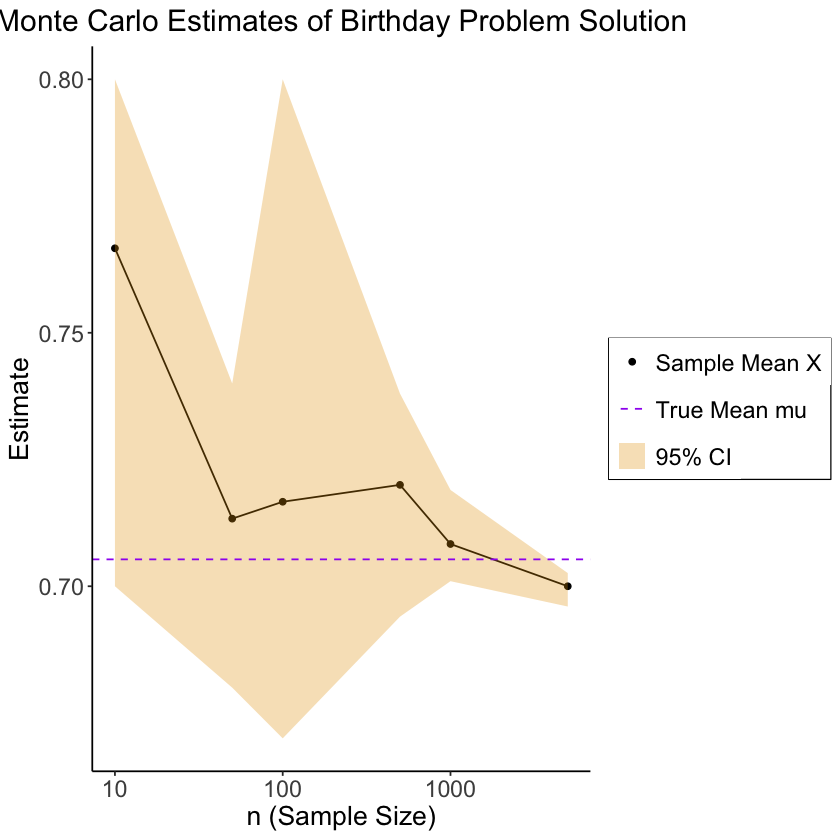

In [16]:
#| label: bday-solns-plot
#| fig-width: 8
#| fig-height: 6
source("../_globals.r")
library(ggplot2)
options(ggplot2.discrete.colour = cbPalette)
global_theme <- ggplot2::theme_classic() + ggplot2::theme(
    plot.title = element_text(hjust = 0.5, size = 18),
    axis.title = element_text(size = 16),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 16, hjust = 0.5),
    legend.text = element_text(size = 14),
    legend.box.background = element_rect(colour = "black")
)
knitr::opts_chunk$set(fig.align = "center")
g_pointsize <- 6
# Bday problem
trials_per_roomsize <- 3
bday_est_lbounds <- c()
bday_est_means <- c()
bday_est_ubounds <- c()
sample_sizes <- c()
for (num_rooms_many in c(10,50,100, 500, 1000, 5000)) {
  cur_size_ests <- c()
  for (trial_num in seq(1,trials_per_roomsize)) {
    many_rooms_df <- gen_bday_rooms(num_rooms_many)
    anyshared_per_room <- many_rooms_df %>%
        group_by(room_num) %>%
        group_map(~ get_shared_bdays(.x, is_grouped = TRUE, return_bool = TRUE))
    anyshared_per_room <- unlist(anyshared_per_room)
    cur_est <- sum(anyshared_per_room > 0) / num_rooms_many
    cur_size_ests <- c(cur_size_ests, cur_est)
  }
  bday_est_lbounds <- c(bday_est_lbounds, min(cur_size_ests))
  bday_est_ubounds <- c(bday_est_ubounds, max(cur_size_ests))
  bday_est_means <- c(bday_est_means, mean(cur_size_ests))
  sample_sizes <- c(sample_sizes, num_rooms_many)
}
result_df <- tibble(n=sample_sizes,est=bday_est_means, lbound=bday_est_lbounds, ubound=bday_est_ubounds)
base_plot <- ggplot(result_df, aes(x=n, y=est)) +
  geom_point(aes(color="black")) +
  geom_line(color="black") +
  geom_ribbon(aes(ymin = lbound, ymax = ubound, fill = cbPalette[1]), alpha = 0.3) +
      geom_hline(aes(yintercept = exact_solution, linetype = "dashed"), color = "purple") +
      scale_color_manual("", values = c("black", "purple"), labels = c("Sample Mean X", "True Mean mu")) +
      scale_linetype_manual("", values = "dashed", labels = "True Mean mu") +
      scale_fill_manual("", values = cbPalette[1], labels = "95% CI") +
      global_theme +
      theme(
          legend.title = element_blank(),
          legend.spacing.y = unit(0, "mm")
      ) +
      labs(
          title = "Monte Carlo Estimates of Birthday Problem Solution",
          x = "n (Sample Size)",
          y = "Estimate"
      )
log_plot <- base_plot + scale_x_log10(breaks=c(10,100,1000,10000,100000), labels=c("10","100","1000","10000","100000"))
log_plot